In [1]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from PIL import Image
from scipy.stats import norm
import glob
import tensorflow as tf
import sys
sys.path.append('..')
from utils import *
#from tensorflow.contrib import layers

### Load Data list names
Rather than load all the data into ram. We just load the names of all the images and annotations. Shuffle the names and partition them into train and test sets. Then we only load the images/annotations when neeed.

In [4]:
base_dir      = '../data/gray_80_80_annotated/'
image_dir     = base_dir + 'images/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'

raw_train = load_data(train_path)
raw_test = load_data(test_path)

# Bin Steering Data
The steering and throttle annotations come in as numbers between 0 and 1023. So our network does not need to have 1024 output neurons we partition the data into bins.

ie:

if we had data consisting of numbers 0-9 :



`data = [1,4,5,0,9,8,5,4,3,2,5,6,7]`

and we binned in lost of 2 the our data would look like this:
```
# bins:  0   1   2   3   4
# nums: 01, 23, 45, 67, 89

binned = [0,2,2,0,4,4,2,2,1,1,2,3,3]
```

In [5]:
NUM_BINS = 8
train = bin_steering_annos(raw_train, NUM_BINS)
test = bin_steering_annos(raw_test, NUM_BINS)
for i,a in train[100:110]:
    print(a)

3.0
3.0
5.0
4.0
0.0
3.0
2.0
2.0
6.0
5.0


## Data Generator

This is what we're going to use to take care of loading our actual images and annotations as we need them. When initalized it shuffles the `data_names` then calling the `get_next_bacth` function returns a tuple of `(images, annotations)`. Calling the `still_has_data`function returns a boolean indicating wether or not all the data has been used up.

In [6]:
from data_generator import DataGenerator

In [7]:
my_data=DataGenerator(batch_size=10, 
                      data_set=train,
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)


Below we plot a histogram of the data we're going to use to train the model. Just to make sure there is not a crazy bias in the data.

*eg: if the video containing the data has the car parked for a few seconds at the beginning and end of a run you may get a large spike in the data around 'go strait'*

anno check: min: 0.0, max: 7.0, mean: 3.3988970588235294


(array([ 436.,  804., 1557.,    0., 1756., 1290.,    0., 1086.,  658.,
         573.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

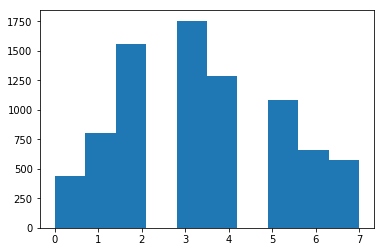

In [8]:
annos = my_data._all_annotations()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))
plt.hist(annos)

anno check: min: 0.0, max: 7.0, mean: 4.0


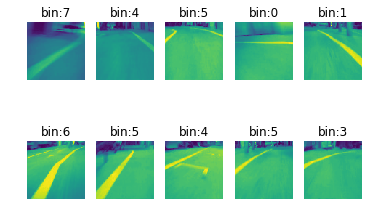

In [9]:
images, annos = my_data.get_next_batch()
print("anno check: min: {}, max: {}, mean: {}".format(np.min(annos), np.max(annos), np.mean(annos)))

for i, (im, an) in enumerate(zip(images[:10], annos[:10])):
    plot = i+1
    plt.subplot(2,5,plot)
#     print("shape: {}".format(np.shape(im[:,:,0])))
    plt.imshow(im[:,:,0])
    plt.axis('off')
    # Covert to +- 100% for hard left or hard right
    angle = an
    plt.title("bin:{}".format(int(angle)))


### Some hyperparams

In [11]:
# epochs           = 5
# input_shape      = (80,80,1)
# num_chans        = 1
# batch_size       = 50

# #input_dim        = np.prod(input_shape)  # flattened size of input_image
# intermediate_dim = 255
# intermediate_dim = 50
# out_dim          = 3
# learning_rate    = 0.001
# optimizer        = tf.train.AdamOptimizer(learning_rate=learning_rate)  

In [12]:
from show_graph import show_graph
from model import Model
car_brain = Model()
#show_graph(car_brain.GetGraph())
# show_graph(tf.get_default_graph().as_graph_def())

### Defining the model

In [13]:
train_gen=DataGenerator(batch_size=50, 
                      data_set=train[:100],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

test_gen=DataGenerator(batch_size=50, 
                      data_set=test[:50],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)

In [14]:
epochs = 2
batch_size = 50
learning_rate = 0.001
car_brain.Train(train_gen=train_gen,
               test_gen=test_gen,
               epochs=epochs)



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Testing



100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Test Loss: 59.290, Test Acc: 0.772
--------------------------------------------------



  0%|          | 0/2 [00:00<?, ?it/s]

Model saved at ./ep_1-step_1-loss_59.3.ckpt
Epoch 2
Training



  0%|          | 0/1 [00:00<?, ?it/s]

Testing



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Test Loss: 15.417, Test Acc: 0.796
--------------------------------------------------
Model saved at ./ep_2-step_1-loss_15.4.ckpt
Done, final best loss: 15.4


[30.70261, 163.06802, 96.98331, 105.57676]
[59.29045, 15.416928]


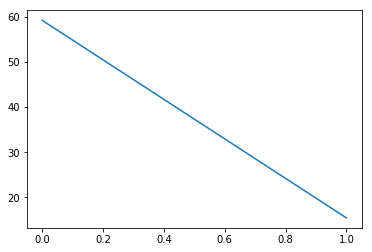

In [15]:
tr_loss, te_loss, te_acc = car_brain.TrainingResults()
print(tr_loss)
print(te_loss)
plt.plot(te_loss)

### Function to encode a list of input images


In [17]:
test_gen = DataGenerator(batch_size=10, 
                      data_set=test[:100],
                      image_dir=image_dir,
                      anno_dir=anno_dir, 
                      num_bins=NUM_BINS)
test_image, anno = test_gen.get_next_batch()
ckpt = "ep_2-step_1-loss_4.73.ckpt"
probs, preds = car_brain.Predict(test_image, ckpt)
pred_angles = car_brain.ExpectedBinToDeg(preds)

INFO:tensorflow:Restoring parameters from ep_2-step_1-loss_4.73.ckpt
[[2.8168146e-10 2.3345915e-03 1.2175106e-02 2.6830512e-03 9.7246414e-01
  9.9242700e-04 9.3506062e-03 4.8575551e-08]
 [5.3883343e-07 2.2390170e-02 4.2680115e-02 8.0398517e-03 9.1131353e-01
  2.7056036e-03 1.2848253e-02 2.1906466e-05]
 [9.3001223e-10 3.8094379e-03 1.3751412e-02 2.4232739e-03 9.7097504e-01
  1.4239051e-03 7.6167760e-03 7.2355078e-08]
 [5.5376890e-09 3.3766020e-03 2.6921786e-02 5.5257832e-03 9.2805570e-01
  1.3250419e-03 3.4794588e-02 5.7993378e-07]
 [9.8486117e-09 6.7716097e-03 2.5041223e-02 5.9980839e-03 9.3058956e-01
  4.8965109e-03 2.6702600e-02 4.2962256e-07]
 [1.6697543e-06 4.4266626e-02 2.3003304e-02 7.8659309e-03 9.0943897e-01
  5.8435206e-03 9.5536616e-03 2.6355407e-05]
 [2.3198561e-08 7.1703084e-03 1.9781625e-02 7.3681804e-03 9.5240879e-01
  2.9164739e-03 1.0353227e-02 1.3991599e-06]
 [7.7577056e-08 7.8215301e-03 2.3371186e-02 5.2852584e-03 9.4820493e-01
  3.3932226e-03 1.1920559e-02 3.2051821e

len:  10


/home/jp/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Prob')

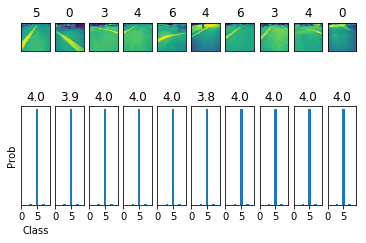

In [20]:
bins = list(range(1,NUM_BINS+1))
y_pos = np.arange(8)
print("len: ", len(annos))
for i, (im, an, prob, pred) in enumerate(zip(images, annos, probs, preds)):
    plot = i + 1
    plt.subplot(2,10,plot)
    plt.xticks([])    
    plt.yticks([])
    plt.title("{}".format(int(an)))
    plt.imshow(im[:,:,0])
    
    plot += 10
    plt.subplot(2,10,plot)
    plt.bar(bins, pr)
    plt.axis([0, 9, 0, 1.])
    plt.yticks([],[])
    plt.title("{:.2}".format(pred))
    
plt.subplot(2,10,11)
plt.xlabel("Class")
plt.ylabel("Prob")
#plt.yticks([0.,0.2, 0.4, 0.6, 0.8, 1.0])

In [ ]:
all_img_paths = get_paths_glob(image_dir+"*.jpg")
all_images    = load_images(all_img_paths)

In [ ]:
tf.reset_default_graph()
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./ep_19-step_50-loss_0.5418351888656616.ckpt')
    for img_pth in all_img_paths:
        name = img_pth.split('/')[-1].split('.')[0]
        img  = load_image(img_pth)
#         img  = img[np.newaxis, :,:, np.newaxis]
        img = np.expand_dims(img, axis=0)
        img = np.expand_dims(img, axis=3)
        img = img.astype('float32')
        ang = sess.run([prediction],feed_dict={x: img,  training: False})
        with open("./to_make_movie.txt", 'a') as file:
            file.write("{}, {}\n".format(name, ang[0][0]))

In [ ]:
#print(all_img_paths[0].split('/')[-1].split('.')[0])
for a, img_pth in zip(angles, all_img_paths):
    im = img_pth.split('/')[-1].split('.')[0]
    with open("./to_make_movie.txt", 'a') as file:
        file.write("{}, {}\n".format(im, a[0:0]))

In [ ]:
from annotate_video_inplace import *
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess,'./ep_19-step_50-loss_0.5418351888656616.ckpt')
    
    video_inference(sess, x, prediction, training, "/home/jp/Documents/FYP/ml/data/videoplayback.mp4", "/home/jp/Desktop/video_infer")

In [ ]:
os.path.exists("/home/jp/Documents/FYP/ml/data/videoplayback.mp4")